# Hack the Feed : Insights from Social Media Data
_By Margaret Awojide_

In [589]:
import numpy as np #Numerical Computations 
import pandas as pd #Data Manipulation and Analysis
from scipy.stats import f_oneway #Statistical Analysis

#Data Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

#Time Series Forecasting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima





import warnings
warnings.filterwarnings("ignore")

In [590]:
link_df = pd.read_csv("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_LinkedIn.csv")
tweet_df = pd.read_csv("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv")
face_df = pd.read_csv("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Facebook.csv")
insta_df = pd.read_csv("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Instagram.csv")

## Data Cleaning

This section applies the use of various functions (including custom functions) to clean and transform the data for further analysis.

The following is constant across all the social media platforms: 
+ Network : Twitter
+ Profile : Stanbic IBTC Bank
+ Reactions is the same as LIkes
+ Impressions is the same as organic impressions

In [591]:
def remove_80_missing(df):
    '''
    This function is used to remove columns where 80% and above of its entries are missing.
    Input : DataFrame
    Output: Dataframe excluding those columns
    '''
    list1 = []
    for i in df.columns:
        x = df[i].isnull().sum()
        y = df.shape[0]
        if (x/y) >= 0.8:
            list1.append(i)
    df = df.drop(list1,axis=1)
    return df

In [592]:
def text_numeric(df, column, delimeter = ",", replacement = "", conversion="float"):
    '''
    This function converts strings that should be numerics to integers. It is especially made for strings with special characters.
    '''
    df[column] = pd.to_numeric(df[column].str.replace(delimeter, replacement), errors='coerce', downcast=conversion)
    return df[column]


In [593]:
def transform_datetime(df, column):
    '''
    This function is used to transform the date column from string to the standard date time format and to extract the weekdays and hours from the dates.
    '''
    df[column] = pd.to_datetime(df[column], format = '%m/%d/%Y %I:%M %p')
    df["Weekday"] = df[column].dt.day_name()
    df['Time'] = df[column].dt.hour
    return df

In [594]:
def remove_columns (df, columns=[]):
    df = df.drop(columns, axis = 1)
    return df

#### Twitter

In [595]:
tweet_df = remove_80_missing(tweet_df)
tweet_df = transform_datetime(tweet_df, "Date")
tweet_df = remove_columns(tweet_df, columns = ["Network", "Post Type", "Profile", "Reactions", "App Opens", "App Install Attempts", "App Engagements", "Organic Impressions"])

In [596]:
#Numeric Columns with Object Datatype were correctly changed.

#For % as delimeter
tweet_df["Engagement Rate (per Impression)"] = text_numeric(tweet_df, "Engagement Rate (per Impression)", delimeter="%")
tweet_df["Click-Through Rate"] = text_numeric(tweet_df, "Click-Through Rate", delimeter = "%")

# For , as delimeter
object_numeric = ["Impressions","Engagements", "Likes", "Shares", 
                  "Post Detail Expand Clicks", "Other Engagements", "Media Views",
                  "Other Post Clicks", "Post Clicks (All)", "Post Media Clicks","Potential Reach"]

for i in object_numeric:
    tweet_df[i] = text_numeric(tweet_df, i)

#### Facebook

In [597]:
face_df = remove_80_missing(face_df)
face_df = transform_datetime(face_df, "Date")
face_df = remove_columns(face_df, columns = ["Network", "Post Type", "Profile", "Link", "Linked Content", "Reactions"])

In [598]:
face_df = face_df.drop(['Organic Impressions', "Viral Impressions", "Non-viral Impressions", "Paid Impressions",
              "Fan Impressions", "Fan Organic Impressions", "Fan Paid Impressions", "Non-fan Impressions",
              "Non-fan Organic Impressions","Non-fan Paid Impressions",'Organic Reach', 'Viral Reach', 
              'Non-viral Reach', 'Paid Reach','Fan Reach', 'Fan Paid Reach', 'Answers'],1)

In [599]:
#Numeric Columns with Object Datatype were correctly changed.

#For % as delimeter
face_df["Engagement Rate (per Impression)"] = text_numeric(face_df, "Engagement Rate (per Impression)", delimeter="%")
face_df["Click-Through Rate"] = text_numeric(face_df, "Click-Through Rate", delimeter = "%")
face_df["Engagement Rate (per Reach)"] = text_numeric(face_df, "Engagement Rate (per Reach)", delimeter="%")

# For , as delimeter
object_numeric = ["Impressions","Reach", "Likes", "Comments"]

for i in object_numeric:
    face_df[i] = text_numeric(face_df, i)

In [600]:
face_df['Positive Reactions'] = face_df["Likes"] + face_df['Love Reactions'] + face_df["Haha Reactions"] + face_df["Wow Reactions"]
face_df["Negative Reactions"] = face_df["Sad Reactions"] + face_df["Angry Reactions"]
face_df = remove_columns(face_df, columns = ["Haha Reactions", "Wow Reactions", "Love Reactions", "Sad Reactions", "Angry Reactions"])

### Instagram

In [601]:
insta_df = remove_80_missing(insta_df)
insta_df = transform_datetime(insta_df, "Date")
insta_df = remove_columns(insta_df, ["Organic Impressions", "Reactions", "Network", "Profile", "Organic Reach"])

In [602]:
insta_df["Engagement Rate (per Impression)"] = text_numeric(insta_df, "Engagement Rate (per Impression)", delimeter="%")
insta_df["Engagement Rate (per Reach)"] = text_numeric(insta_df, "Engagement Rate (per Reach)", delimeter="%")

# For , as delimeter
object_numeric = ["Impressions","Reach", "Likes", "Comments"]

for i in object_numeric:
    insta_df[i] = text_numeric(insta_df, i)

### Linkdeln

In [603]:
link_df = remove_80_missing(link_df)
link_df = transform_datetime(link_df, "Date")
#Tags, Organic Impressions, Reactions, Post Clicks (All), Network, Profile
link_df = remove_columns(link_df, columns = ['Tags', 'Organic Impressions', 'Reactions',
                                             'Post Clicks (All)', 'Network', 'Profile'])
link_df = transform_datetime(link_df, "Date")

In [604]:
link_df["Engagement Rate (per Impression)"] = text_numeric(link_df, "Engagement Rate (per Impression)", delimeter="%")
link_df["Click-Through Rate"] = text_numeric(link_df, "Click-Through Rate", delimeter="%")

# For , as delimeter
object_numeric = ["Impressions","Engagements", "Post Link Clicks"]

for i in object_numeric:
    insta_df[i] = text_numeric(link_df, i)

In [605]:
face_df.columns

Index(['Date', 'Post ID', 'Content Type', 'Sent by', 'Post', 'Impressions',
       'Reach', 'Engagement Rate (per Impression)',
       'Engagement Rate (per Reach)', 'Engagements', 'Likes', 'Comments',
       'Shares', 'Click-Through Rate', 'Other Post Clicks',
       'Post Clicks (All)', 'Post Photo View Clicks', 'Negative Feedback',
       'Engaged Users', 'Engaged Fans', 'Users Talking About This',
       'Unique Reactions', 'Unique Comments', 'Unique Shares',
       'Unique Answers', 'Unique Post Clicks', 'Unique Post Photo View Clicks',
       'Unique Other Post Clicks', 'Unique Negative Feedback', 'Weekday',
       'Time', 'Positive Reactions', 'Negative Reactions'],
      dtype='object')

## Data Exploration
This section analyzes the data to draw initial insights from the data. It is also the bedrock for future statistical analysis, NLP and time series analysis

### Twitter

In [606]:
tweet_df['Content Type'].value_counts().sort_values(ascending=False) #There are more picture posts than other content categories

Photo    6213
Text     1018
Video     883
Link      415
Name: Content Type, dtype: int64

In [607]:
tweet_df.columns

Index(['Date', 'Post ID', 'Content Type', 'Sent by', 'Link', 'Post',
       'Linked Content', 'Impressions', 'Potential Reach',
       'Engagement Rate (per Impression)', 'Engagements', 'Likes', 'Comments',
       'Shares', 'Click-Through Rate', 'Post Link Clicks', 'Other Post Clicks',
       'Post Clicks (All)', 'Post Media Clicks', 'Post Hashtag Clicks',
       'Post Detail Expand Clicks', 'Profile Clicks', 'Other Engagements',
       'Follows from Post', 'Unfollows from Post', 'Media Views', 'Weekday',
       'Time'],
      dtype='object')

In [608]:
tweet_df.groupby('Content Type')[['Impressions', 'Engagement Rate (per Impression)', 'Potential Reach', 'Likes','Comments','Shares']].mean() 

#In general posts with videos have more engagement and potential reach than the rest of the content type.

,Impressions,Engagement Rate (per Impression),Potential Reach,Likes,Comments,Shares
Content Type,,,,,,
Link,1997.767944,2.197536,236537.937500,9.006667,1.833811,9.559184
Photo,3376.817139,2.983351,285375.187500,21.887001,6.668621,14.587908
Text,2609.051514,1.978822,229914.640625,8.927135,4.878719,6.828886
Video,2982.329590,3.689060,322949.031250,28.506128,6.582418,17.458149


In [609]:
tweet_df['Sent by'].value_counts()

                     4240
Sophia Amuka         3250
Aramide Salami        541
Blessing Ubah         251
Kemi Amoo              92
Dunni Ogunsanya        76
Damilare Oyekanmi      71
Patience Nnaji          3
Lilian Ibekwe           2
Rebecca Oyebode         1
Kanayo Obiano           1
Philip Nwagwunor        1
Name: Sent by, dtype: int64

In [610]:
tweet_df.groupby('Sent by')[['Impressions', 'Engagement Rate (per Impression)', 'Potential Reach', 'Likes','Comments','Shares']].mean() 

,Impressions,Engagement Rate (per Impression),Potential Reach,Likes,Comments,Shares
Sent by,,,,,,
,3250.115234,2.787929,252794.515625,19.977854,4.302866,13.291037
Aramide Salami,3573.784668,2.745963,268818.656250,18.846790,4.989648,9.993220
Blessing Ubah,2065.902832,2.859069,335023.343750,11.902834,7.578947,NaN
Damilare Oyekanmi,2880.926514,5.801029,357375.718750,49.455883,13.441176,NaN
Dunni Ogunsanya,2076.560547,2.309545,221681.656250,5.446154,0.727273,7.461538
Kanayo Obiano,28.000000,0.000000,NaN,0.000000,0.000000,NaN
Kemi Amoo,3269.277832,3.347667,330310.687500,23.444445,8.444444,NaN
Lilian Ibekwe,33.500000,9.880000,NaN,1.000000,0.500000,NaN
Patience Nnaji,878.000000,0.680000,178429.000000,1.000000,0.000000,1.000000


In [611]:
tweet_df['Weekday'].value_counts().sort_values(ascending=False)

Friday       1482
Thursday     1417
Wednesday    1329
Tuesday      1278
Monday       1227
Saturday     1162
Sunday        634
Name: Weekday, dtype: int64

In [612]:
tweet_df.groupby('Weekday')[['Impressions', 'Engagement Rate (per Impression)', 'Potential Reach', 'Likes','Comments','Shares']].mean() 

,Impressions,Engagement Rate (per Impression),Potential Reach,Likes,Comments,Shares
Weekday,,,,,,
Friday,3062.318359,2.873214,276776.59375,17.105783,5.506696,11.209702
Monday,3167.087646,2.899850,279306.65625,30.239130,5.816092,16.702335
Saturday,2996.026855,2.938555,284303.62500,19.486177,5.899167,11.114068
Sunday,3324.251709,3.064379,301722.56250,23.742575,8.437908,14.612717
Thursday,3241.505615,2.660445,275795.03125,18.996010,6.578113,11.415645
Tuesday,3054.773193,2.805355,277145.81250,16.927753,6.011976,12.337037
Wednesday,3532.794189,3.240085,281426.25000,20.962036,6.533051,15.720207


### Facebook

In [613]:
face_df['Content Type'].value_counts().sort_values(ascending=False) #There are more picture posts than other content categories

Photo    8308
Video     964
Text      339
Link      192
Name: Content Type, dtype: int64

In [614]:
face_df.columns

Index(['Date', 'Post ID', 'Content Type', 'Sent by', 'Post', 'Impressions',
       'Reach', 'Engagement Rate (per Impression)',
       'Engagement Rate (per Reach)', 'Engagements', 'Likes', 'Comments',
       'Shares', 'Click-Through Rate', 'Other Post Clicks',
       'Post Clicks (All)', 'Post Photo View Clicks', 'Negative Feedback',
       'Engaged Users', 'Engaged Fans', 'Users Talking About This',
       'Unique Reactions', 'Unique Comments', 'Unique Shares',
       'Unique Answers', 'Unique Post Clicks', 'Unique Post Photo View Clicks',
       'Unique Other Post Clicks', 'Unique Negative Feedback', 'Weekday',
       'Time', 'Positive Reactions', 'Negative Reactions'],
      dtype='object')

In [615]:
face_df.groupby('Content Type')[['Impressions', 'Engagement Rate (per Impression)', 'Reach', 'Likes','Comments','Shares']].mean() 

#In general posts with videos have more engagement and potential reach than the rest of the content type.

,Impressions,Engagement Rate (per Impression),Reach,Likes,Comments,Shares
Content Type,,,,,,
Link,4358.048340,4.049500,3696.554199,74.595741,12.585107,5.510638
Photo,6842.515625,3.573424,6061.395020,96.309128,20.486803,9.167695
Text,7757.430664,3.839925,7291.733887,61.069092,50.298183,2.323636
Video,2438.097900,7.127437,2263.020996,38.770077,12.793180,3.922992


In [616]:
face_df['Sent by'].value_counts()

                     7090
Damilare Oyekanmi    1657
Aramide Salami        428
Blessing Ubah         328
Sophia Amuka          209
Kemi Amoo              48
Dunni Ogunsanya        43
Name: Sent by, dtype: int64

In [617]:
face_df.groupby('Sent by')[['Impressions', 'Engagement Rate (per Impression)', 'Reach', 'Likes','Comments','Shares']].mean() 

,Impressions,Engagement Rate (per Impression),Reach,Likes,Comments,Shares
Sent by,,,,,,
,7091.112793,3.468933,6149.011230,107.393158,22.407389,10.809021
Aramide Salami,7164.379883,3.193807,6311.088867,95.827492,16.369272,9.522911
Blessing Ubah,4234.950684,3.216075,4170.238281,35.749226,14.476780,0.953560
Damilare Oyekanmi,4405.938965,5.365965,4327.321777,35.144241,16.030304,0.963636
Dunni Ogunsanya,1213.068970,3.160000,796.000000,77.425003,22.350000,23.700000
Kemi Amoo,3856.666748,5.136087,3780.270752,40.875000,15.854167,1.875000
Sophia Amuka,5435.444824,8.894135,5284.306152,52.028709,17.732058,2.334928


In [618]:
face_df['Weekday'].value_counts().sort_values(ascending=False)

Wednesday    2008
Friday       1566
Thursday     1556
Tuesday      1417
Monday       1415
Saturday     1110
Sunday        731
Name: Weekday, dtype: int64

In [619]:
face_df.groupby('Weekday')[['Impressions', 'Engagement Rate (per Impression)', 'Reach', 'Likes','Comments','Shares']].mean() 

,Impressions,Engagement Rate (per Impression),Reach,Likes,Comments,Shares
Weekday,,,,,,
Friday,6254.898438,3.893622,5528.061523,70.928818,22.865318,7.791347
Monday,6671.874023,3.586303,5903.311035,71.933174,18.321678,9.536131
Saturday,6720.708496,4.935607,6098.329590,67.182846,18.528746,6.259189
Sunday,6862.247070,3.408202,6358.972168,86.356125,24.737892,6.576923
Thursday,6377.328125,4.233532,5634.358398,132.418686,22.075605,8.385164
Tuesday,6750.604492,4.447829,6039.116699,76.053528,21.885181,8.467029
Wednesday,5470.818359,3.487021,4738.358887,106.245491,17.521814,9.987784


### Instagram

In [620]:
insta_df['Content Type'].value_counts().sort_values(ascending=False) #There are more picture posts than other content categories

Photo       8256
Video       1002
Carousel     742
Name: Content Type, dtype: int64

In [621]:
insta_df.columns

Index(['Date', 'Post ID', 'Post Type', 'Content Type', 'Sent by', 'Link',
       'Post', 'Impressions', 'Reach', 'Engagement Rate (per Impression)',
       'Engagement Rate (per Reach)', 'Engagements', 'Likes', 'Comments',
       'Saves', 'Weekday', 'Time', 'Post Link Clicks'],
      dtype='object')

In [622]:
insta_df.groupby('Content Type')[['Impressions', 'Engagement Rate (per Impression)', 'Reach', 'Likes','Comments']].mean() 

#In general posts with videos have more engagement and potential reach than the rest of the content type.

,Impressions,Engagement Rate (per Impression),Reach,Likes,Comments
Content Type,,,,,
Carousel,1070.901001,3.610428,1285.888794,83.265106,9.926154
Photo,1071.281128,4.715106,1563.491211,101.674187,13.993177
Video,1165.627930,9.786121,1769.284668,127.234924,14.240000


In [623]:
insta_df['Sent by'].value_counts()

                     4967
Blessing Ubah        2707
Aramide Salami       1733
Kemi Amoo             315
Sophia Amuka          192
Damilare Oyekanmi      86
Name: Sent by, dtype: int64

In [624]:
insta_df.groupby('Sent by')[['Impressions', 'Engagement Rate (per Impression)', 'Reach', 'Likes','Comments']].mean() 

,Impressions,Engagement Rate (per Impression),Reach,Likes,Comments
Sent by,,,,,
,1090.876953,8.544663,1202.620483,171.825150,13.793134
Aramide Salami,1036.392334,3.792944,1512.089722,89.898659,9.948442
Blessing Ubah,1093.279419,2.640203,1949.537842,42.130436,15.547548
Damilare Oyekanmi,1294.373535,2.816628,1532.720947,32.558140,20.833334
Kemi Amoo,1051.913330,2.590032,2131.096436,46.781349,11.663594
Sophia Amuka,1136.140503,2.539365,1767.642090,33.063156,18.623377


In [625]:
insta_df['Weekday'].value_counts().sort_values(ascending=False)

Wednesday    1723
Friday       1606
Thursday     1568
Monday       1481
Tuesday      1414
Saturday     1275
Sunday        933
Name: Weekday, dtype: int64

In [626]:
insta_df.groupby('Weekday')[['Impressions', 'Engagement Rate (per Impression)', 'Reach', 'Likes','Comments']].mean() 

,Impressions,Engagement Rate (per Impression),Reach,Likes,Comments
Weekday,,,,,
Friday,1174.980469,8.083467,1505.827515,185.944031,13.357927
Monday,1074.015137,3.717978,1481.859863,72.973465,15.325620
Saturday,1019.240479,7.393308,1925.128296,171.947021,9.882353
Sunday,1157.317871,4.419717,1917.811401,78.588089,14.902174
Thursday,1054.666626,4.242905,1508.480225,76.358932,14.231908
Tuesday,1019.335571,3.579753,1534.095581,68.061066,15.340137
Wednesday,1089.614014,4.707916,1276.297485,63.690460,13.107795


### Linkdeln

In [627]:
link_df['Content Type'].value_counts().sort_values(ascending=False) #There are more picture posts than other content categories

Photo       6490
Video        924
Text         233
Link         110
Poll           2
Document       1
Name: Content Type, dtype: int64

In [628]:
link_df.columns

Index(['Date', 'Post ID', 'Post Type', 'Content Type', 'Sent by', 'Link',
       'Post', 'Impressions', 'Engagement Rate (per Impression)',
       'Engagements', 'Likes', 'Comments', 'Shares', 'Click-Through Rate',
       'Post Link Clicks', 'Weekday', 'Time'],
      dtype='object')

In [629]:
link_df.groupby('Content Type')[['Impressions', 'Engagement Rate (per Impression)', 'Likes','Comments','Shares']].mean() 

#In general posts with videos have more engagement and potential reach than the rest of the content type.

,Impressions,Engagement Rate (per Impression),Likes,Comments,Shares
Content Type,,,,,
Document,1438.000000,18.080000,9.000000,0.000000,0.000000
Link,1352.375000,24.847187,13.687500,0.187500,3.531250
Photo,1029.012207,7.976286,15.863168,0.834924,1.450000
Poll,22357.000000,2.730000,15.500000,2.500000,0.000000
Text,1504.735596,3.562163,11.052885,2.447115,0.432692
Video,1254.466431,2.433062,16.308598,2.832744,1.308598


In [630]:
link_df['Sent by'].value_counts()

                     2974
Blessing Ubah        2426
Sophia Amuka         1625
Kemi Amoo             337
Aramide Salami        289
Damilare Oyekanmi      97
Dunni Ogunsanya        12
Name: Sent by, dtype: int64

In [631]:
link_df.groupby('Sent by')[['Impressions', 'Engagement Rate (per Impression)', 'Likes','Comments','Shares']].mean() 

,Impressions,Engagement Rate (per Impression),Likes,Comments,Shares
Sent by,,,,,
,1500.434814,17.340931,21.220597,2.258631,2.074898
Aramide Salami,1153.656738,11.163433,21.305970,0.805970,1.839552
Blessing Ubah,765.504272,2.864182,11.212947,0.648637,0.682283
Damilare Oyekanmi,858.375000,3.534583,9.822917,0.604167,0.437500
Dunni Ogunsanya,940.727295,2.044545,6.818182,0.181818,1.727273
Kemi Amoo,805.822632,3.193333,11.923547,0.853211,0.917431
Sophia Amuka,1164.905273,2.964024,16.862683,0.865861,1.849968


In [632]:
link_df['Weekday'].value_counts().sort_values(ascending=False)

Wednesday    1791
Monday       1158
Tuesday      1151
Friday       1146
Thursday     1132
Saturday      818
Sunday        564
Name: Weekday, dtype: int64

In [633]:
link_df.groupby('Weekday')[['Impressions', 'Engagement Rate (per Impression)', 'Likes','Comments','Shares']].mean() 

,Impressions,Engagement Rate (per Impression),Likes,Comments,Shares
Weekday,,,,,
Friday,1076.790649,5.213302,14.680208,1.156250,1.407292
Monday,1071.987915,7.269606,16.110101,1.143434,1.565657
Saturday,1114.868286,4.341884,15.898551,0.664032,1.277997
Sunday,1051.349854,3.830249,14.548757,0.900574,1.030593
Thursday,1164.716919,8.759372,17.385463,1.014317,1.317181
Tuesday,964.381531,9.400431,15.193846,0.741538,1.311795
Wednesday,1126.225098,8.875653,15.963846,2.004108,1.665571


## Statistical Analysis

Using Analysis of Variance (ANOVA), this section checks if: 
+ There is a statistically significant difference in engagement rate across the different social media groups
+ There is a statistically significant difference in engagement rate across the different content types for each social media group.

In [634]:
insta_engagement = insta_df['Engagement Rate (per Impression)'].dropna()
face_engagement = face_df['Engagement Rate (per Impression)'].dropna()
link_engagement = link_df['Engagement Rate (per Impression)'].dropna()
tweet_engagement = tweet_df['Engagement Rate (per Impression)'].dropna()

result = f_oneway(insta_engagement, face_engagement, link_engagement, tweet_engagement)
print ("Test Statistic : ", round(result[0],4))
print ("P Value: ", result[1])

if result[1] < 0.05:
    print ("There is a significant difference between groups")
else: 
    print ("There is no significant difference")

engagement_socials = pd.Series({'Instagram': insta_engagement.mean(), 'Facebook' : face_engagement.mean(), 
                      'Linkdeln': link_engagement.mean(), 'Twitter': tweet_engagement.mean()})

print (engagement_socials)


Test Statistic :  34.0419
P Value:  5.905215882790533e-22
There is a significant difference between groups
Instagram    5.198337
Facebook     4.003146
Linkdeln     7.173245
Twitter      2.910116
dtype: float32


In [635]:
photo = tweet_df[tweet_df['Content Type'] == 'Photo']['Engagement Rate (per Impression)'].dropna()
video = tweet_df[tweet_df['Content Type'] == 'Video']['Engagement Rate (per Impression)'].dropna()
link = tweet_df[tweet_df['Content Type'] == 'Link']['Engagement Rate (per Impression)'].dropna()
text = tweet_df[tweet_df['Content Type'] == 'Text']['Engagement Rate (per Impression)'].dropna()

result = f_oneway(photo, video, link, text)

print ("Test Statistic : ", round(result[0]))
print ("P Value: ", result[1],4)

if result[1] < 0.05:
    print ("There is a significant difference between groups")
else: 
    print ("There is no significant difference")


display(tweet_df.groupby('Content Type')['Engagement Rate (per Impression)'].mean())

Test Statistic :  61
P Value:  1.0773705220491855e-38 4
There is a significant difference between groups


Content Type
Link     2.197536
Photo    2.983351
Text     1.978822
Video    3.689060
Name: Engagement Rate (per Impression), dtype: float32

In [636]:
photo = face_df[face_df['Content Type'] == 'Photo']['Engagement Rate (per Impression)'].dropna()
video = face_df[face_df['Content Type'] == 'Video']['Engagement Rate (per Impression)'].dropna()
link = face_df[face_df['Content Type'] == 'Link']['Engagement Rate (per Impression)'].dropna()
text = face_df[face_df['Content Type'] == 'Text']['Engagement Rate (per Impression)'].dropna()

result = f_oneway(photo, video, link, text)

print ("Test Statistic : ", round(result[0]))
print ("P Value: ", result[1],4)

if result[1] < 0.05:
    print ("There is a significant difference between groups")
else: 
    print ("There is no significant difference")


display(face_df.groupby('Content Type')['Engagement Rate (per Impression)'].mean())

Test Statistic :  9
P Value:  6.6550497293970426e-06 4
There is a significant difference between groups


Content Type
Link     4.049500
Photo    3.573424
Text     3.839925
Video    7.127437
Name: Engagement Rate (per Impression), dtype: float32

In [637]:
photo = insta_df[insta_df['Content Type'] == 'Photo']['Engagement Rate (per Impression)'].dropna()
video = insta_df[insta_df['Content Type'] == 'Video']['Engagement Rate (per Impression)'].dropna()
carousel = insta_df[insta_df['Content Type'] == 'Carousel']['Engagement Rate (per Impression)'].dropna()

result = f_oneway(photo, video, carousel)

print ("Test Statistic : ", round(result[0],4))
print ("P Value: ", result[1])

if result[1] < 0.05:
    print ("There is a significant difference between groups")
else: 
    print ("There is no significant difference")


display(insta_df.groupby('Content Type')['Engagement Rate (per Impression)'].mean())

Test Statistic :  12.1698
P Value:  5.2792522100375435e-06
There is a significant difference between groups


Content Type
Carousel    3.610428
Photo       4.715106
Video       9.786121
Name: Engagement Rate (per Impression), dtype: float32

In [638]:
photo = link_df[link_df['Content Type'] == 'Photo']['Engagement Rate (per Impression)'].dropna()
video = link_df[link_df['Content Type'] == 'Video']['Engagement Rate (per Impression)'].dropna()
link = link_df[link_df['Content Type'] == 'Link']['Engagement Rate (per Impression)'].dropna()
text = link_df[link_df['Content Type'] == 'Text']['Engagement Rate (per Impression)'].dropna()
poll = link_df[link_df['Content Type'] == 'Poll']['Engagement Rate (per Impression)'].dropna()
document = link_df[link_df['Content Type'] == 'Document']['Engagement Rate (per Impression)'].dropna()
result = f_oneway(photo, video, link, text)

print ("Test Statistic : ", round(result[0]))
print ("P Value: ", result[1],4)

if result[1] < 0.05:
    print ("There is a significant difference between groups")
else: 
    print ("There is no significant difference")


display(link_df.groupby('Content Type')['Engagement Rate (per Impression)'].mean())

Test Statistic :  8
P Value:  4.481741911204625e-05 4
There is a significant difference between groups


Content Type
Document    18.080000
Link        24.847187
Photo        7.976286
Poll         2.730000
Text         3.562163
Video        2.433062
Name: Engagement Rate (per Impression), dtype: float32

## Time Series Analysis & Forecasting

This section analyzes the trend in the data (monthly data) and attempts to forecast future values as well using tools such as auto arima, arima and adfuller test among others. 

In [639]:
def month_aggregation (df, value):
    '''
    This function returns the monthly sum of the value specified. 
    '''
    
    new_df = pd.DataFrame()
    df['year_month'] = df['Date'].dt.strftime('%Y-%m')
    values = df.groupby('year_month')[value].sum()
    new_df['Year'] = values.index
    new_df['Values'] = values.values
    new_df['Year'] = pd.to_datetime(new_df['Year'], format = ('%Y-%m'))
    return new_df

In [640]:
def plot_line(new_df, label):

    '''
    This function produces a customized line plot of the time series monthly data.
    '''
    
    fig, ax = plt.subplots(figsize = (6,4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

    ax.plot(new_df['Year'], new_df['Values'])
    plt.xticks(rotation=45)

    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)

    ax.set_ylabel(label)
    ax.set_title('Line Plot showing trend in ' + str(label))


    # Show the plot
    plt.show()

In [641]:
def adf_test (new_df,differencing = 0):

    '''
    This function tests for stationarity using the augmented dickey fuller test and plots the corresponding 
    autocorrelation and partial autocorrelation plots of the data. 
    
    '''
    
    if differencing > 0: 
        for i in range(differencing):
            new_df['Values'] = new_df['Values'].diff(differencing)
    
    new_df = new_df.dropna()
            
    print (f'Differencing: {differencing}')
    result = adfuller(new_df['Values'])
    print(f'ADF Statistic: {round(result[0],4)}')
    print (f'P-value: {result[1]}')
    if result[1] < 0.05:
        print ("The time series is likely stationary")
    else:
        print ("The time series is not likely stationary")
    
    plot_acf(new_df['Values'])
    plot_pacf(new_df['Values'])

In [642]:
def forecast_values(new_df, d, p, q):
        
        '''
        This function manually seeks to find the best ARIMA for forecasting. It attempts to forecast for the next 12 months. 

        Input : new_df : Data to be forecasted (ideally a month-based dataset)
                p,d,q : The proposed order of the ARIMA model
        
        Output : 
        Model Summary containing the details of the ARIMA model 
        RMSE Containing the accuracy of the model using Root Mean Squared Error
        A line plot showing some past data and the forecast data for the next 12 months
        '''
        new_df = new_df.set_index("Year")
        size = new_df.shape[0]
        train = new_df[: int(size *0.8)]
        test = new_df[int(size * 0.8) :]

        model = ARIMA(train, order=(p, d, q))

        results = model.fit()
        forecast_intial_result = results.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast_intial_result))

        # Forecast for the next 12 months
        results = ARIMA(new_df, order = (p,d,q)).fit()
        forecast_result = results.forecast(steps=12)
        index = pd.date_range(start=test.index[-1], periods=13, freq='M')[1:]
        forecast_df = pd.DataFrame({'Year': index, 'Value': forecast_result})

        #Print Forecast Results
        print(f'RMSE: {rmse}')
        print (results.summary())

        #Plot forecast results
        plt.figure(figsize = (10,5))
        plt.plot(new_df['Values'][80:], label = "Past Data")
        plt.plot(forecast_df['Year'], forecast_df['Value'], label = "Future Forecast", color = 'orange')
        plt.title ("Time Series Forecasting (12 Months)")
        plt.legend()
        plt.show()


In [643]:
def arima_forecast(new_df):
  '''
  This function automatically finds the best ARIMA model for forecasting by iterating through and picking the best model.
  It attempts to forecast for the next 12 months. 

  Input : new_df : Data to be forecasted (ideally a month-based dataset)
  
  Output : 
  Model Summary containing the details of the ARIMA model
  The best model from a list of possible model combinations
  A line plot showing some past data and the forecast data for the next 12 months
  '''
  new_df = new_df.set_index("Year")
  size = new_df.shape[0]
    
  results = auto_arima(new_df, stepwise=True, trace = True)

  # Forecast for the next 12 months
  forecast_result = results.predict(n_periods=12)
  index = pd.date_range(start=new_df.index[-1], periods=13, freq='M')[1:]
  forecast_df = pd.DataFrame({'Year': index, 'Value': forecast_result})
  print (forecast_df)

  #Print Forecast Results
  print (results.summary())

  #Plot forecast results
  plt.figure(figsize = (10,5))
  plt.plot(new_df['Values'][80:], label = "Past Data")
  plt.plot(forecast_df['Year'], forecast_df['Value'], label = "Future Forecast", color = 'orange')
  plt.title ("Time Series Forecasting (12 Months)")
  plt.legend()
  plt.show()

### Twitter

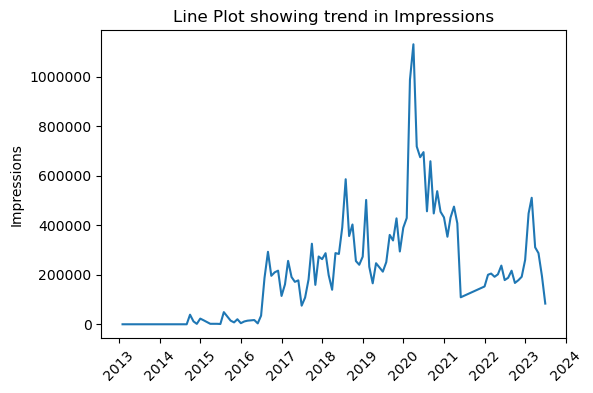

Differencing: 0
ADF Statistic: -2.91
P-value: 0.04420155444269903
The time series is likely stationary
Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2950.471, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2950.569, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2950.749, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2949.955, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2948.578, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2946.722, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2948.475, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2949.154, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2948.207, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2950.216, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2944.385, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2947.967, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2948.757, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2946.313, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2946.342, Time=0.21 sec
 ARIMA(0,1

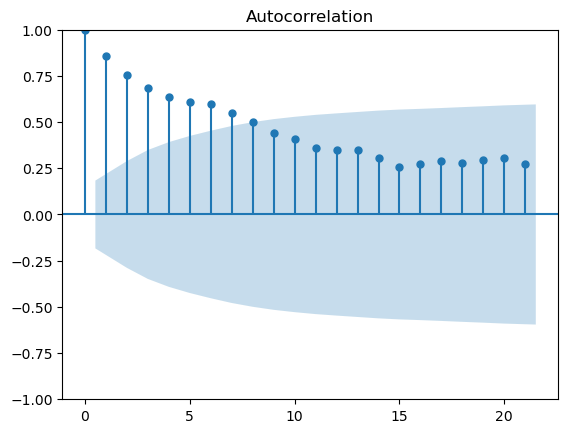

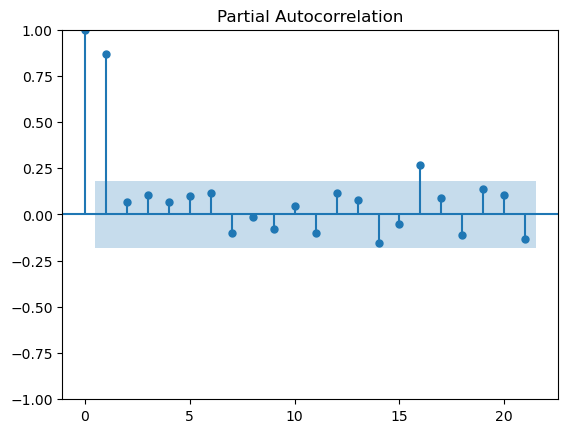

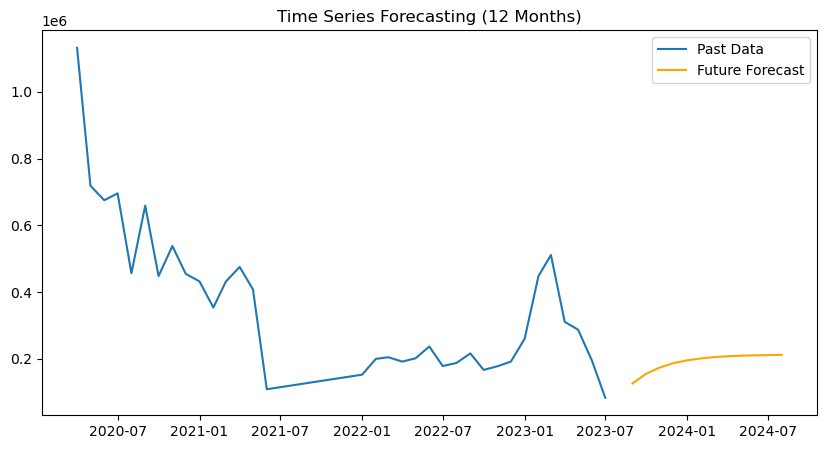

In [644]:
data = month_aggregation(tweet_df, "Impressions")
plot_line(data, label = "Impressions")
adf_test(data, differencing=0)
arima_forecast(data)

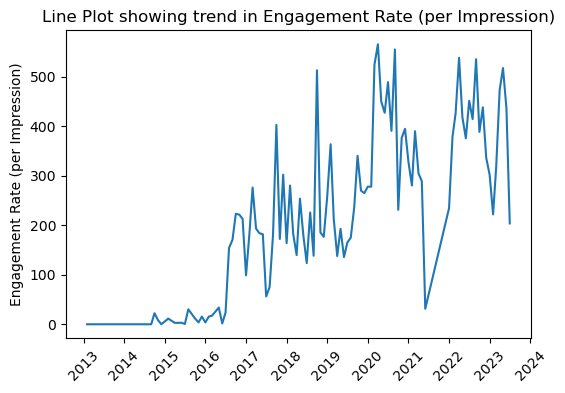

Differencing: 0
ADF Statistic: -1.4608
P-value: 0.5528201697921736
The time series is not likely stationary
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1372.300, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1358.097, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1348.650, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1370.335, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1347.396, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1348.442, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1347.383, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1347.547, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1347.983, Time=0.42 sec
 ARIMA(0,1,

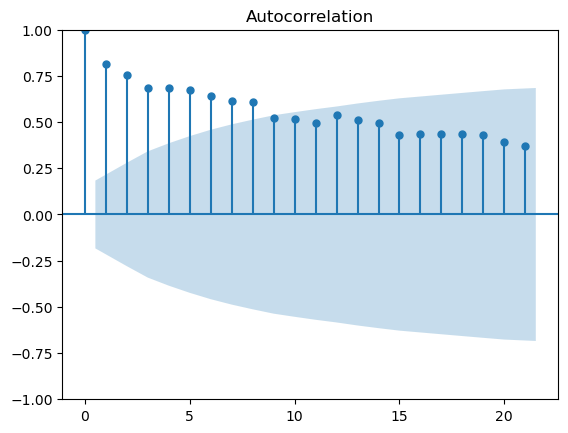

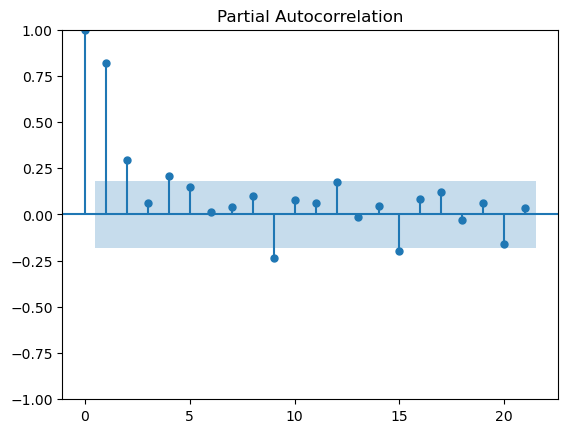

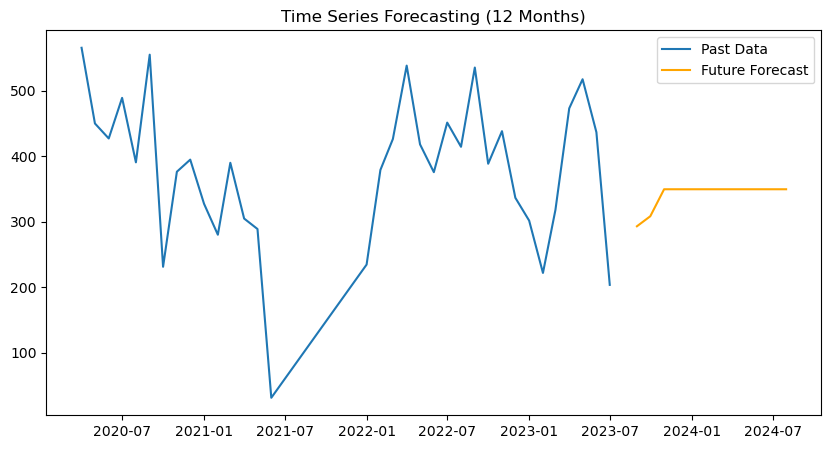

In [645]:
data = month_aggregation(tweet_df, "Engagement Rate (per Impression)")
plot_line(data, label = "Engagement Rate (per Impression)")
adf_test(data, differencing=0)
arima_forecast(data)